<a href="https://colab.research.google.com/github/Camicb/Copper-Forecasting/blob/main/Part_1_Price_Copper_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Part 1. Copper Price Forecasting**

## 1. Introduction

In Chile there are 26 mining deposits that produce 5.7 million tons of copper per year, which represents 28% of world production [[1]](https://www.elmostrador.cl/noticias/opinion/2021/03/28/importancia-del-cobre-cu-en-la-descarbonizacion-de-la-economia-mundial-y-su-impacto-en-chile/). This relative abundance of copper has made it the main export of Chile and therefore its contribution is vital to the Chilean economy. Anticipating the price of copper allows the estimation of the profitability of related projects and their viability over time.

Forecasting is the prediction on data with a time dimension. In this project, I will forecast the price of copper, with data manually extracted from the Chilean Copper Commission, [COCHILCO](https://boletin.cochilco.cl/estadisticas/grafico.asp?tipo_metal=1) from years 1999 to 2021 (today).

The data was extracted, joined, and cleaned using Microsoft Excel, and then uploaded as a [Google Sheet](https://drive.google.com/file/d/1Hyi1jYV-1RJ2dCAKlbApFT8gx0x9i0U0/view?usp=sharing). For this analysis, I will use traditional ARIMA models and the library Facebook Prophet. I will not consider other variables that have been associated with the increase or decrease of the prices; the impacts of these variables will be study in the second part of this project.

The copper price is determined worldwide by the [London Metal Exchange](https://www.lme.com/en-GB/Metals/Non-ferrous/Copper#tabIndex=0). 
The data provided by COCHILCO have 2 variables:


*   **Fecha** : Datetime
*   **Precio Nominal Cobre Diario (¢/lb)**: the price, in cents per pound of copper



## 2. Import Required Libraries



In [1]:
# Installing required libraries

!pip install pystan -q
!pip install fbprophet -q
!pip install statsmodels -q
!pip install pmdarima -q
!pip install scipy -q

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [3]:
# For reproducibility
np.random.seed(2021)

## 3. Exploratory Data Analysis and Preprocessing

In [4]:
# Loading the data
price = pd.read_excel('/content/drive/MyDrive/DATASETS/Copper/precio_cobre.xlsx')

In [5]:
# Inspecting the data
price.tail()
print(' ')
price.info()
print(' ')
price.describe()

,Fecha,Precio Nominal Cobre Diario (¢/lb)
5615,2021-03-24,408.96
5616,2021-03-25,398.30
5617,2021-03-26,405.01
5618,2021-03-29,405.63
5619,2021-03-30,398.64


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5620 entries, 0 to 5619
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               5620 non-null   datetime64[ns]
 1   Precio Nominal Cobre Diario (¢/lb)  5620 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 87.9 KB
 


,Precio Nominal Cobre Diario (¢/lb)
count,5620.000000
mean,237.851087
std,109.970242
min,59.830000
25%,131.167500
50%,265.645000
75%,324.015000
max,460.310000


In [6]:
# Redefining variables for simplification purposes
price.rename(columns={'Fecha': 'ds'}, inplace=True)
price.rename(columns={'Precio Nominal Cobre Diario (¢/lb)': 'y'}, inplace=True)

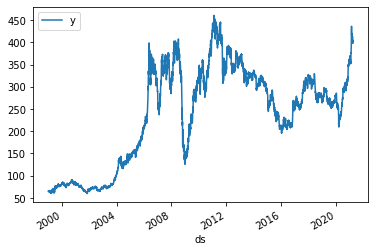

In [7]:
# Visualizing data
price.plot(x='ds',y='y')

The visualization clearly shows the crisis of 2008, and that this has a more negative impact on copper prices compared to the crisis produced by COVID-19. Therefore, for modeling I will only use data from 2011 onwards.

In [8]:
# Resampling data
price_res = price[price['ds']>='2011-01-01']
price_res.head()

,ds,y
3031,2011-01-04,442.43
3032,2011-01-05,429.14
3033,2011-01-06,435.04
3034,2011-01-07,426.33
3035,2011-01-10,425.65


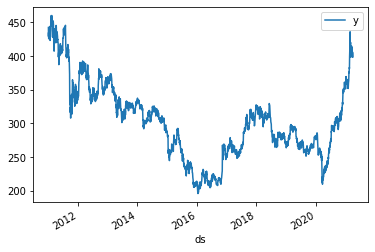

In [9]:
# Visualizing resampled data
price_res.plot(x='ds', y='y')

I will split data into training and testing datasets, considering predictions for an horizon of 60 days just to keep things simple.

In [10]:
# Spliting data 
train = price_res[0:-60] 
test = price_res[-60:]   

In [11]:
print(train.shape)
print(test.shape)

(2529, 2)
(60, 2)


## 4. Modeling

### 4.1 ARIMA based models

ARIMA, or Autoregressive Integrated Moving Average, is a very popular statistical method for time series forecasting. 

An ARIMA model can be considered as a special type of regression model. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

*   **p** (past values used for forecasting the next value)
*   **q** (past forecast errors used to predict the future values)
*  **d** (order of differencing)

Parameter tuning for ARIMA consumes a lot of time. So for this project I will use auto ARIMA, which automatically selects the best combination of (p,q,d) that provides the least error. 

In [12]:
# Inspecting ARIMA models

train.index = train['ds']
test.index = test['ds']

model = auto_arima(train['y'], 
                   start_p=1, start_q=1, 
                   max_p=5, max_q=5, 
                   max_d=5, m=1, 
                   max_D=5, trace=True, 
                   error_action='ignore', 
                   random_state=2021)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13968.090, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13968.435, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13968.368, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13968.540, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13966.623, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.854 seconds


In [13]:
# Model selection
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2529
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6982.312
Date:                Wed, 31 Mar 2021   AIC                          13966.623
Time:                        02:12:15   BIC                          13972.458
Sample:                             0   HQIC                         13968.740
                               - 2529                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        14.6749      0.255     57.513      0.000      14.175      15.175
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):              1135.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Making predictions for the next 130 days
predictions = pd.DataFrame(model.predict(n_periods= 60))
predictions.index=test.index
predictions.columns = ['predictions']
predictions

,predictions
ds,
2021-01-06,358.97
2021-01-07,358.97
2021-01-08,358.97
2021-01-11,358.97
2021-01-12,358.97
2021-01-13,358.97
2021-01-14,358.97
2021-01-15,358.97
2021-01-18,358.97


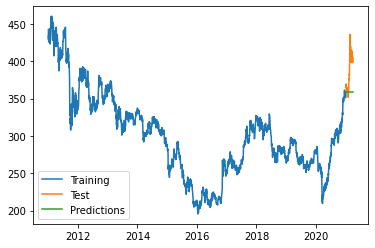

In [15]:
# Visualizing results
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Test')
plt.plot(predictions['predictions'], label='Predictions')
plt.legend()

In [16]:
# Metrics
mean_squared_error(test['y'], predictions['predictions'])

1336.0139049999987

An auto ARIMA model uses past data to understand the pattern in the time series. Using these values, as its evident from the plot, the model could not capture the trend or the seasonal part; therefore, the predictions are not close to the real values and the error is significant.

###4.2 Facebook Prophet

Facebook Prophet is open source software released by Facebook’s Core Data Science team. 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It requires two variables : a column with the datetimes named 'ds', and column with the values named 'y'.




In [17]:
# Creating model
m= Prophet(daily_seasonality=True)
m.fit(train)
future_price = m.make_future_dataframe(periods=84,freq='D') 
future_price.tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds
2608,2021-03-26
2609,2021-03-27
2610,2021-03-28
2611,2021-03-29
2612,2021-03-30


In [18]:
# Making predictions
forecast = m.predict(future_price)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2608,2021-03-26,292.342930,270.385996,315.488096
2609,2021-03-27,291.066426,268.066874,313.146374
2610,2021-03-28,291.038034,267.538854,314.376049
2611,2021-03-29,291.982602,269.657967,314.081396
2612,2021-03-30,292.262605,270.122232,315.806492


The model provided the values:

**yhat**: the forecasted value (the predicted values for y)

**yhat_lower**: the lower bound of the forecast

**yhat_upper**: the upper bound of the forecast

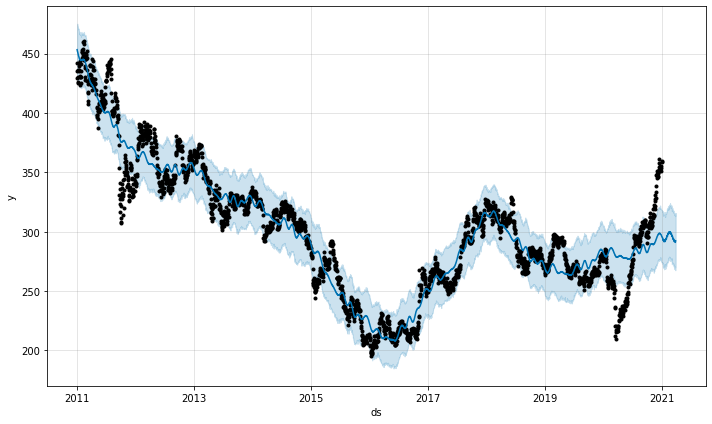

In [19]:
# Plot the forecast
fig1 = m.plot(forecast, uncertainty=True)


Prophet plots the observed values of time series (black dots), the forecasted values (blue lines) and the uncertainty intervals of the forecasts ( blue shaded region).

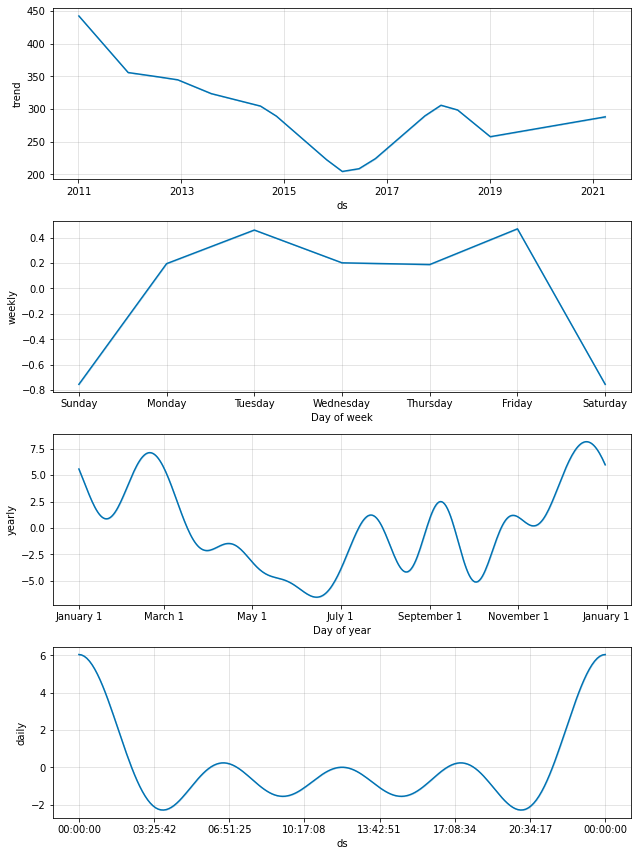

In [20]:
# Plot forecast components
fig2 = m.plot_components(forecast)

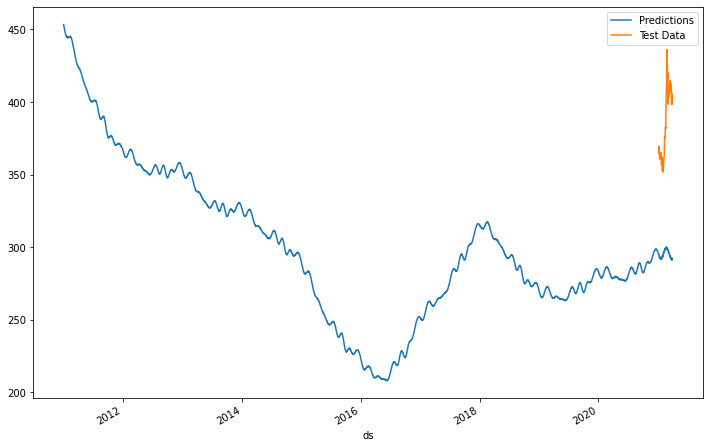

In [21]:
# Plot test data and predictions
ax_price=forecast.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='Test Data',ax=ax_price)


In [22]:
# Metrics
y_test = test['y']
y_predict = forecast['yhat'][-60:]
mean_squared_error(y_test, y_predict)

8808.844297372096

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time-series datasets but fails in this case, where the error is even worse compared with the ARIMA model.


## 5. Conclusion
As it turns out, copper prices do not have a particular trend or seasonality. They highly depend on the national and international markets situation. Hence forecasting techniques like ARIMA, SARIMAX and Prophet would not show good results for these problems. 

##6. Bibliography

*  https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

*  https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

*  https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA

*  https://facebook.github.io/prophet/docs/quick_start.html#python-api

*  https://sailajakarra.medium.com/facebook-prophet-for-time-series-cf26be1be274

